# Preprocessing

## Check which patients have 5min and 15min bg measurements

In [1]:
import os
import pandas as pd

from src.features.tuners import XGBHyperparameterTuner

In [2]:
train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(train_data_file, index_col=0, low_memory=False)
patient_ids_train_data = train_data['p_num'].unique()
patient_ids_train_data

array(['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12'],
      dtype=object)

In [3]:
test_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'test.csv')
test_data = pd.read_csv(test_data_file, index_col=0, low_memory=False)
patient_ids_test_data = test_data['p_num'].unique()
patient_ids_test_data

array(['p01', 'p02', 'p04', 'p05', 'p06', 'p10', 'p11', 'p12', 'p15',
       'p16', 'p18', 'p19', 'p21', 'p22', 'p24'], dtype=object)

In [4]:
all_patient_ids = sorted(list(set(train_data['p_num'].unique().tolist() + test_data['p_num'].unique().tolist())))
all_patient_ids

['p01',
 'p02',
 'p03',
 'p04',
 'p05',
 'p06',
 'p10',
 'p11',
 'p12',
 'p15',
 'p16',
 'p18',
 'p19',
 'p21',
 'p22',
 'p24']

In [5]:
bg_columns = [train_data.columns[i] for i in range(len(train_data.columns)) if 'bg-' in train_data.columns[i]]

columns = ['p_num'] + bg_columns
joined = pd.concat([train_data[columns], test_data[columns]], axis=0)

joined['no_nan_values'] = joined[bg_columns].notna().sum(axis=1)
joined['nan_values'] = joined[bg_columns].isna().sum(axis=1)

# sum up the number of nan and non_nan values for each patient
grouped = joined.groupby('p_num').agg({'no_nan_values': 'sum', 'nan_values': 'sum'})
grouped['total_values'] = grouped['no_nan_values'] + grouped['nan_values']

# make this relative to the total number of values
grouped['rel_nan_values'] = round(grouped['nan_values'] / grouped['total_values'], 2)
grouped['rel_no_nan_values'] = round(grouped['no_nan_values'] / grouped['total_values'], 2)

grouped['in_train_data'] = grouped.index.isin(patient_ids_train_data)
grouped['in_test_data'] = grouped.index.isin(patient_ids_test_data)

grouped = grouped.drop(columns=['no_nan_values', 'nan_values', 'total_values'])

grouped

,rel_nan_values,rel_no_nan_values,in_train_data,in_test_data
p_num,,,,
p01,0.67,0.33,True,True
p02,0.01,0.99,True,True
p03,0.01,0.99,True,False
p04,0.01,0.99,True,True
p05,0.68,0.32,True,True
p06,0.68,0.32,True,True
p10,0.01,0.99,True,True
p11,0.02,0.98,True,True
p12,0.02,0.98,True,True


# Model selection

Based in this table we can see that there are 3 groups of patients:
1. Patients that are only in the train data
2. Patients that are only in the test data
3. Patients that are in both the train and test data

We can use this information to decide which patients we want to train a specific model on and which patients we want to use a generic model for.

Patients that are in both the train and test data will be used to train a specific model on.

All other patients will be used to train a generic model on.

In [6]:
# show the p_num of the patients that are in both the train and test data
patients_with_own_model = list(grouped[(grouped['in_train_data'] == True) & (grouped['in_test_data'] == True)].index)
patients_with_generic_model = list(grouped[(grouped['in_train_data'] == False) & (grouped['in_test_data'] == True)].index)

## Train a specific model for patients that are in both the train and test data

-----------p01-----------
Best hyperparameters found.
RMSE: 1.3178568055286524


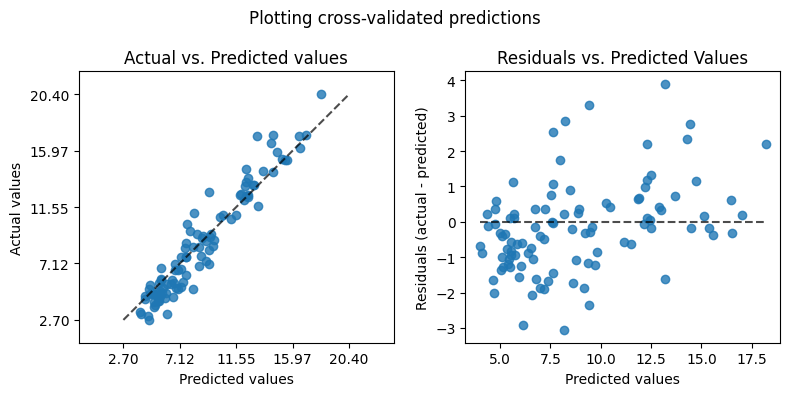

-----------p02-----------
Best hyperparameters found.
RMSE: 0.10521944337704084


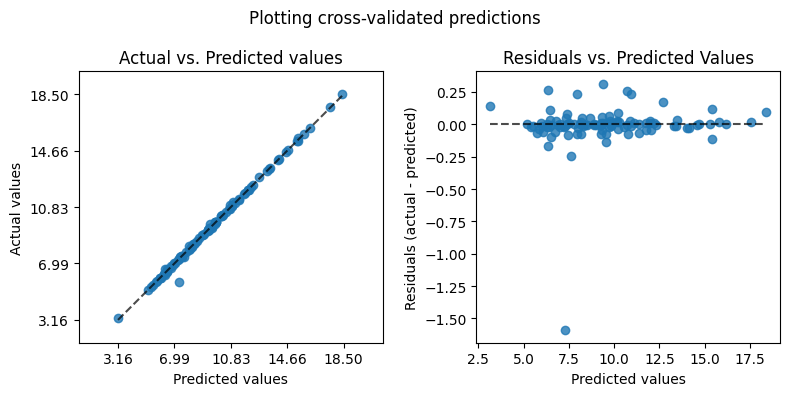

-----------p04-----------
Best hyperparameters found.
RMSE: 0.28005842937371617


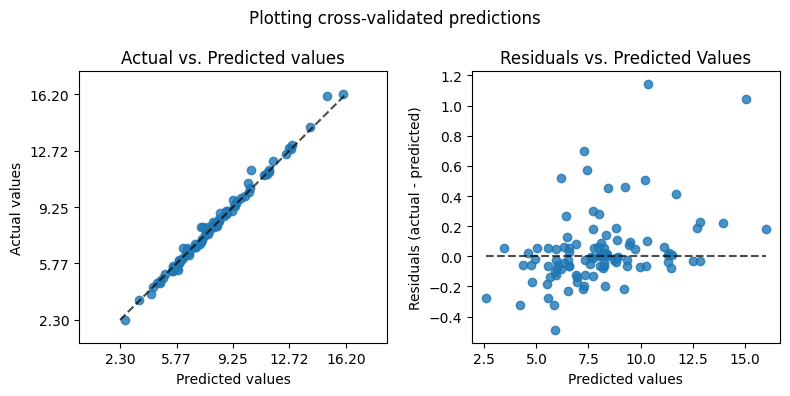

-----------p05-----------
Best hyperparameters found.
RMSE: 0.08267626130757097


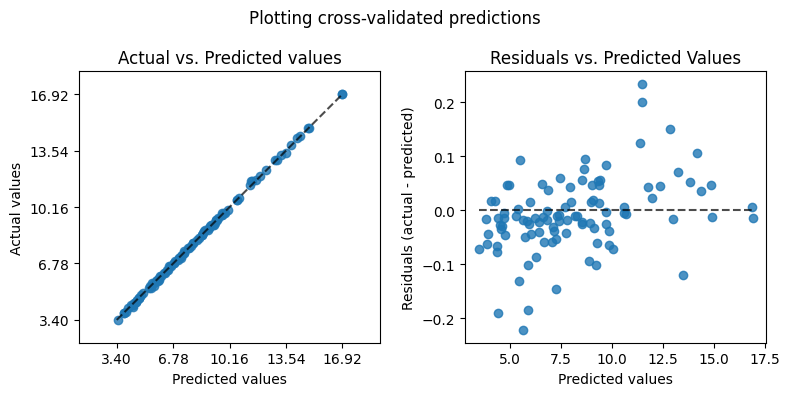

-----------p06-----------
Best hyperparameters found.
RMSE: 1.0849667455444707


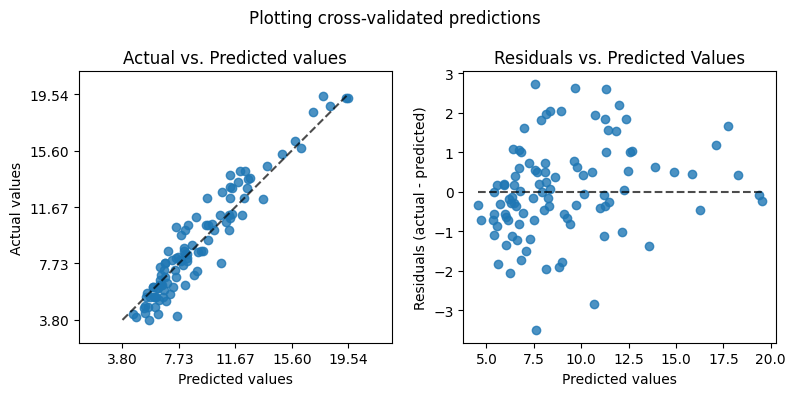

-----------p10-----------
Best hyperparameters found.
RMSE: 0.02923006597949089


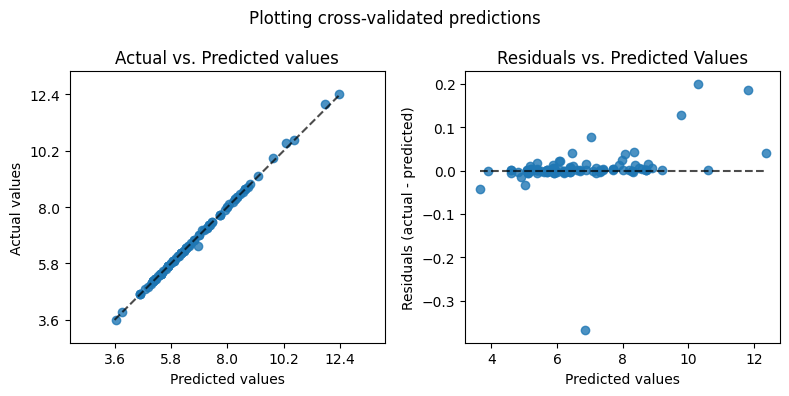

-----------p11-----------
Best hyperparameters found.
RMSE: 0.1178234053823996


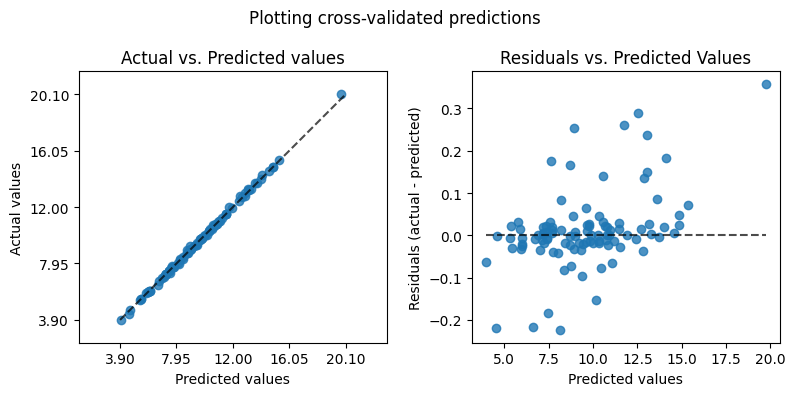

-----------p12-----------
Best hyperparameters found.
RMSE: 0.26048578227070235


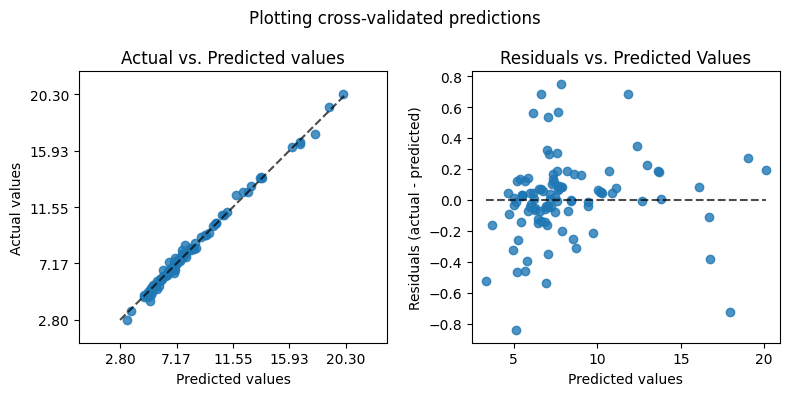

In [7]:
import joblib
from pipelines import pipeline

for patient_id in patients_with_own_model:
    print(f'-----------{patient_id}-----------')
    data = train_data[train_data['p_num'] == patient_id]
    train_data_patient = pipeline.fit_transform(data)
    X = train_data_patient.drop(columns=['bg+1:00'])
    y = train_data_patient['bg+1:00']
    tuner = XGBHyperparameterTuner(search_space='deep')
    tuner.fit(X=X, y=y)

    print('Best hyperparameters found.')
    print(f'RMSE: {tuner.get_rmse()}')
    tuner.show_chart()

    joblib.dump(tuner.get_best_model(), f'XGBRegressor.{patient_id}.model.pkl')

## Train a generic model for patients that are only in the test data

------Tune-generic model-with-XGBRegressor--------
Calculating best hyperparameters...
Best hyperparameters found.


OrderedDict([('alpha', 10.0),
             ('colsample_bytree', 0.3),
             ('gamma', 0),
             ('lambda', 1e-10),
             ('learning_rate', 0.052549197538376655),
             ('max_depth', 15),
             ('min_child_weight', 10),
             ('n_estimators', 998),
             ('scale_pos_weight', 1),
             ('subsample', 1.0)])

RMSE: 0.5407103524650221


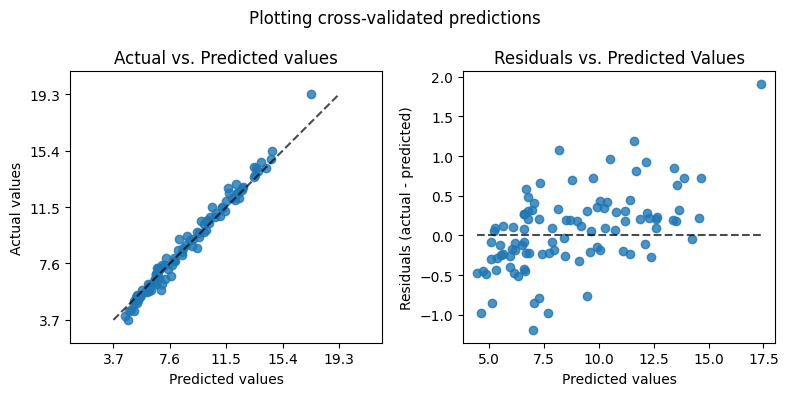

------Tune-generic model-with-ExtraTreesRegressor--------
Calculating best hyperparameters...


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.


Best hyperparameters found.


OrderedDict([('max_depth', 14),
             ('max_features', None),
             ('max_leaf_nodes', 31),
             ('min_impurity_decrease', 0.0),
             ('min_samples_leaf', 10),
             ('min_samples_split', 2),
             ('n_estimators', 100),
             ('random_state', 42)])

RMSE: 2.0856756026717567


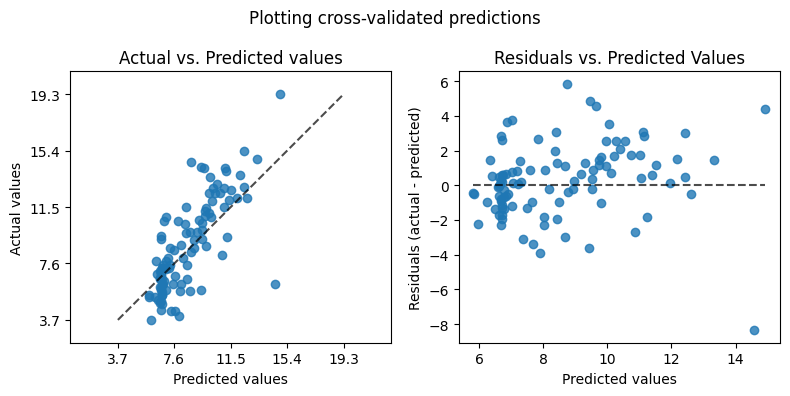

------Tune-generic model-with-BaggingRegressor--------
Calculating best hyperparameters...
Best hyperparameters found.


OrderedDict([('max_features', 0.8085497108014549),
             ('max_samples', 1.0),
             ('n_estimators', 100)])

RMSE: 0.6701025232165359


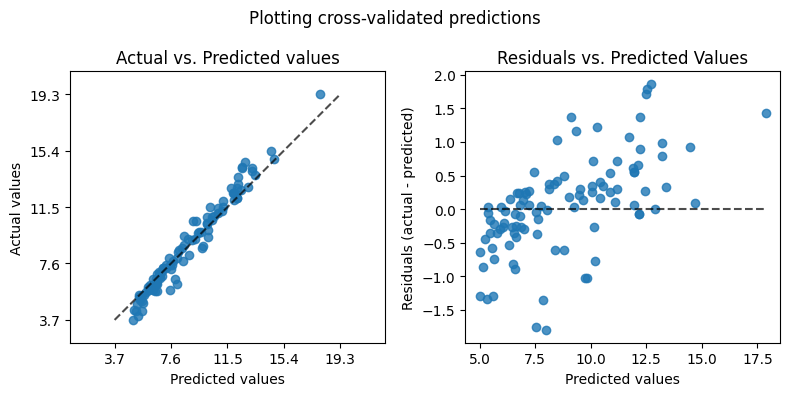

In [9]:
from src.features.tuners import ExtraTreesHyperparameterTuner, BaggingHyperparameterTuner, XGBHyperparameterTuner


def tune(tuner, X, y):
    print(f'------Tune-generic model-with-{tuner.__name__}--------')
    print('Calculating best hyperparameters...')
    tuner.fit(X=X, y=y)
    print('Best hyperparameters found.')
    display(tuner.get_params())
    print(f'RMSE: {tuner.get_rmse()}')
    tuner.show_chart()
    joblib.dump(tuner.get_best_model(), f'{tuner.__name__}.generic.model.pkl')


train_data = pipeline.fit_transform(train_data)
X = train_data.drop(columns=['bg+1:00'])
y = train_data['bg+1:00']

tune(XGBHyperparameterTuner(search_space='deep'), X, y)
tune(ExtraTreesHyperparameterTuner(), X, y)
tune(BaggingHyperparameterTuner(), X, y)


In [ ]:
import os
import pandas as pd

train_data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
df = pd.read_csv(train_data_file, index_col=0, low_memory=False)
df.head()

In [ ]:
from pipelines import preprocessing_pipeline

df = preprocessing_pipeline.fit_transform(df)
display(df.head())
df.describe()

In [ ]:
from pipelines import standardization_pipeline

df = standardization_pipeline.fit_transform(df)
display(df.head())
df.describe()